In [37]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.model_selection import train_test_split

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import acquire
import explore
import split_scale


# Acquire the Data

In [2]:
# df = acquire.get_zillow_data_from_sql()
df = pd.read_csv('zillow.csv', index_col=0) # adding index_col=0 creates the unique row identifers

df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name,distribution_of_tax_rates
0,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.90,Los Angeles,0.017045
1,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.69,Los Angeles,0.015270
2,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.72,Orange,0.011153
3,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.19,Los Angeles,0.012497
4,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.47,Los Angeles,0.011915


In [3]:
df.shape

(15011, 10)

In [4]:
df.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips_number',
       'propertylandusetypeid', 'propertylandusedesc', 'home_value',
       'tax_amount', 'county_name', 'distribution_of_tax_rates'],
      dtype='object')

In [5]:
df .info()
# look like square_feet has some nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15035
Data columns (total 10 columns):
bathrooms                    15011 non-null float64
bedrooms                     15011 non-null float64
square_feet                  15011 non-null int64
fips_number                  15011 non-null float64
propertylandusetypeid        15011 non-null int64
propertylandusedesc          15011 non-null object
home_value                   15011 non-null float64
tax_amount                   15011 non-null float64
county_name                  15011 non-null object
distribution_of_tax_rates    15011 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.3+ MB


In [6]:
df.describe()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,home_value,tax_amount,distribution_of_tax_rates
count,15011.000000,15011.000000,15011.000000,15011.000000,15011.0,1.501100e+04,15011.000000,15011.000000
mean,2.326161,3.312904,1942.109653,6049.387049,261.0,5.413327e+05,6593.327045,0.013431
std,1.021834,0.942635,1001.672617,21.238488,0.0,7.306264e+05,8449.893492,0.006881
min,0.000000,0.000000,300.000000,6037.000000,261.0,1.050400e+04,51.260000,0.000787
25%,2.000000,3.000000,1275.000000,6037.000000,261.0,1.985960e+05,2706.520000,0.011603
50%,2.000000,3.000000,1679.000000,6037.000000,261.0,3.848860e+05,4771.470000,0.012305
75%,3.000000,4.000000,2346.000000,6059.000000,261.0,6.449440e+05,7678.315000,0.013697
max,11.000000,12.000000,15450.000000,6111.000000,261.0,2.385837e+07,276797.830000,0.452884


In [7]:
df.isna().sum()

bathrooms                    0
bedrooms                     0
square_feet                  0
fips_number                  0
propertylandusetypeid        0
propertylandusedesc          0
home_value                   0
tax_amount                   0
county_name                  0
distribution_of_tax_rates    0
dtype: int64

In [8]:
# df.square_feet.value_counts(dropna=False)
# assert(df['square_feet'] >= 0 ).all()
# so this tells us we have some values that are less than zero 
# since we have an AssertionError we know there are some in our dataframe

# What to do with our errors and outliers

In [9]:
# dropping nulls
df.dropna(inplace=True)

In [10]:
df.isna().sum()
# perfect we have cleaned up those NaN's with the mean of the column

bathrooms                    0
bedrooms                     0
square_feet                  0
fips_number                  0
propertylandusetypeid        0
propertylandusedesc          0
home_value                   0
tax_amount                   0
county_name                  0
distribution_of_tax_rates    0
dtype: int64

# Check data again

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15035
Data columns (total 10 columns):
bathrooms                    15011 non-null float64
bedrooms                     15011 non-null float64
square_feet                  15011 non-null int64
fips_number                  15011 non-null float64
propertylandusetypeid        15011 non-null int64
propertylandusedesc          15011 non-null object
home_value                   15011 non-null float64
tax_amount                   15011 non-null float64
county_name                  15011 non-null object
distribution_of_tax_rates    15011 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.3+ MB


In [12]:
# so we need to change some of the datatypes. we can do this individually or all in one
df = df.astype(
    {'square_feet': 'int64',
     'propertylandusedesc': 'category'
    })

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15035
Data columns (total 10 columns):
bathrooms                    15011 non-null float64
bedrooms                     15011 non-null float64
square_feet                  15011 non-null int64
fips_number                  15011 non-null float64
propertylandusetypeid        15011 non-null int64
propertylandusedesc          15011 non-null category
home_value                   15011 non-null float64
tax_amount                   15011 non-null float64
county_name                  15011 non-null object
distribution_of_tax_rates    15011 non-null float64
dtypes: category(1), float64(6), int64(2), object(1)
memory usage: 1.2+ MB


In [14]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name,distribution_of_tax_rates
0,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.90,Los Angeles,0.017045
1,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.69,Los Angeles,0.015270
2,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.72,Orange,0.011153
3,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.19,Los Angeles,0.012497
4,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.47,Los Angeles,0.011915


In [15]:
df.fips_number.value_counts()

6037.0    9620
6059.0    4096
6111.0    1295
Name: fips_number, dtype: int64

In [16]:

df['county_name'] = df.fips_number.map({6037: 'Los Angeles', 
                                        6059: 'Orange',
                                        6111: 'Ventura'
                                       })


In [17]:
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name,distribution_of_tax_rates
0,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.90,Los Angeles,0.017045
1,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.69,Los Angeles,0.015270
2,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.72,Orange,0.011153
3,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.19,Los Angeles,0.012497
4,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.47,Los Angeles,0.011915


In [18]:
df['distribution_of_tax_rates'] = df['tax_amount'] / df['home_value']
df.head()

,bathrooms,bedrooms,square_feet,fips_number,propertylandusetypeid,propertylandusedesc,home_value,tax_amount,county_name,distribution_of_tax_rates
0,2.0,3.0,1458,6037.0,261,Single Family Residential,136104.0,2319.90,Los Angeles,0.017045
1,1.0,2.0,1421,6037.0,261,Single Family Residential,35606.0,543.69,Los Angeles,0.015270
2,3.0,4.0,2541,6059.0,261,Single Family Residential,880456.0,9819.72,Orange,0.011153
3,2.0,3.0,1650,6037.0,261,Single Family Residential,614000.0,7673.19,Los Angeles,0.012497
4,1.0,2.0,693,6037.0,261,Single Family Residential,274237.0,3267.47,Los Angeles,0.011915


# Splitting the data

In [19]:
# need to drop some columns 
df = df.drop(columns=['fips_number', 'propertylandusetypeid', 'propertylandusedesc',
                 'tax_amount', 'county_name', 'distribution_of_tax_rates'])

In [20]:
# Define X and y variables
X = df[['bathrooms', 'bedrooms', 'square_feet']]
y = df[['home_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=123)

In [21]:
X_train.head()

,bathrooms,bedrooms,square_feet
5498,3.0,2.0,1736
2042,3.0,3.0,1565
1494,2.0,3.0,1334
11013,2.0,2.0,1503
8148,2.0,3.0,1372


# Modeling

In [41]:
# Create Model
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=df).fit()

# Predict Model
ols_yhat = ols_model.predict(X_train)

In [43]:
# Create a DataFrame for evaluating my model(s) and Baseline Value
ols_eval = y_train.copy()
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [44]:
# Add Baseline Column
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)

In [45]:
# Add Baseline
ols_eval['baseline_yhat'] = ols_eval['actual'].mean()

In [46]:
# Add OLS predictions columns
ols_eval['ols_yhat'] = ols_model.predict(X_train)

In [47]:
# Calculate and Add residuals colomns for plotting
ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual

In [48]:
# Compute the RMSE for our ols Model and Baseline using our created dataframe
baseline_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat))

ols_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat))

print(f'My model has value: {ols_RMSE < baseline_RMSE}')

My model has value: True


In [49]:
# Compute the RMSE for the model we created
ols_r2 = round(ols_model.rsquared,3)

ols_p_value = ols_model.f_pvalue

print(f'My R-squared score is significant: {ols_p_value < .05}')

My R-squared score is significant: True


### Visualize Residuals

(array([1.000e+00, 3.000e+00, 6.000e+00, 2.300e+01, 5.800e+01, 2.240e+02,
        7.580e+02, 2.279e+03, 2.655e+03, 1.870e+02]),
 array([ 2.56175668,  3.78668763,  5.01161859,  6.23654954,  7.4614805 ,
         8.68641145,  9.91134241, 11.13627336, 12.36120432, 13.58613527,
        14.81106623]),
 <a list of 10 Patch objects>)

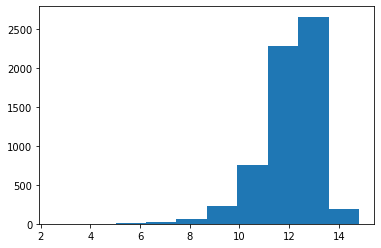

In [50]:
# create a histogram 
plt.hist(np.log(ols_eval.residuals))

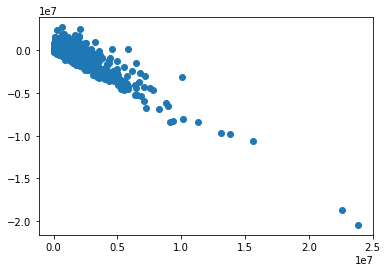

In [51]:
# create a scatter plot of the residuals and look for patters
plt.scatter(ols_eval.actual, ols_eval.residuals)

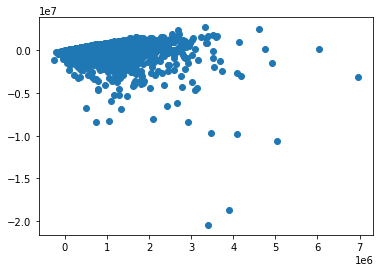

In [52]:
# look at predictions vs residuals
plt.scatter(ols_eval.ols_yhat, ols_eval.residuals)

In [27]:
model = lm().fit(X_train, y_train)

In [28]:
predictions = model.predict(X_test)

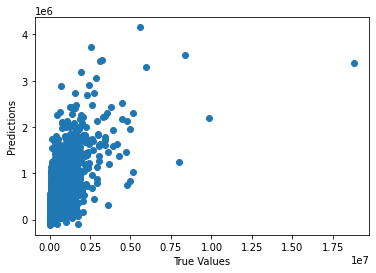

In [36]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()